# 4 Point OpenCV getPerspective Transform Example

### Import Packages

In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [2]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [3]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	
    # the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	
    # now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	
    # return the ordered coordinates
	return rect

In [4]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	
    # compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	
    # compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	
    # now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	
    # compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	
    # return the warped image
	return warped

In [5]:
'''
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", help = "path to the image file")
ap.add_argument("-c", "--coords",
	help = "comma seperated list of source points")
args = vars(ap.parse_args())
'''
args = {
    "image"  : "data/4Point/example_01.png",
    "coords" : "[(73, 239), (356, 117), (475, 265), (187, 443)]"
}

args2 = {
    "image"  : "data/4Point/example_02.png",
    "coords" : "[(101, 185), (393, 151), (479, 323), (187, 441)]"
}

args3 = {
    "image"  : "data/4Point/example_03.png",
    "coords" : "[(63, 242), (291, 110), (361, 252), (78, 386)]"
}

In [6]:
# load the image and grab the source coordinates (i.e. the list of
# of (x, y) points)
# NOTE: using the 'eval' function is bad form, but for this example
# let's just roll with it -- in future posts I'll show you how to
# automatically determine the coordinates without pre-supplying them
image = cv2.imread(args["image"])
pts = np.array(eval(args["coords"]), dtype = "float32")

In [7]:
# apply the four point tranform to obtain a "birds eye view" of
# the image
warped = four_point_transform(image, pts)

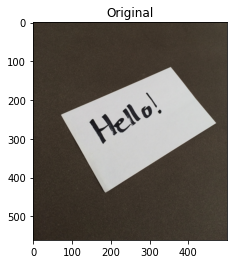

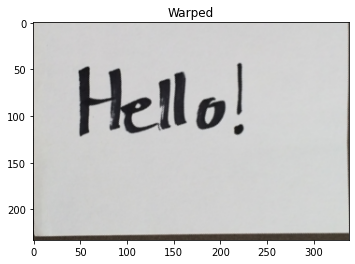

In [8]:
# show the original and warped images
plt_imshow("Original", image)
plt_imshow("Warped", warped)

# Document Scanner

In [9]:
from skimage.filters import threshold_local

In [22]:
'''
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required = True,
	help = "Path to the image to be scanned")
args = vars(ap.parse_args())
'''
args = {
    "image"  : "data/4Point/page.jpg",
}

args1 = {
    "image"  : "data/4Point/receipt.jpg",
}

args2 = {
    "image"  : "data/4Point/receipt_573065707_1000.jpeg",
}

STEP 1: Edge Detection


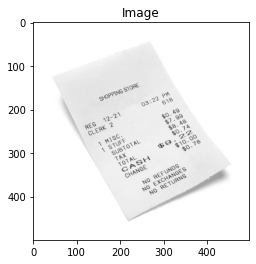

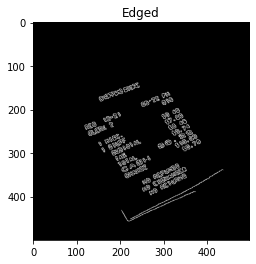

In [23]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread(args2["image"])
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
print("STEP 1: Edge Detection")
plt_imshow("Image", image)
plt_imshow("Edged", edged)

STEP 2: Find contours of paper


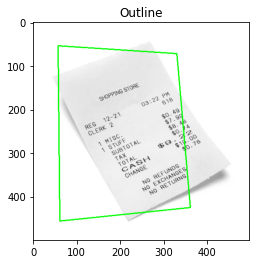

In [24]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt_imshow("Outline", image)

STEP 3: Apply perspective transform


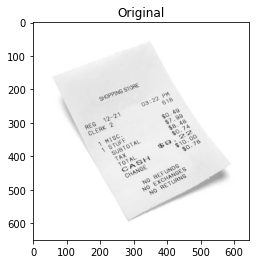

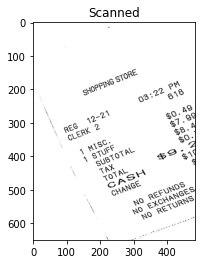

In [25]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

# show the original and scanned images
print("STEP 3: Apply perspective transform")
plt_imshow("Original", imutils.resize(orig, height = 650))
plt_imshow("Scanned", imutils.resize(warped, height = 650))